<a href="https://colab.research.google.com/github/ZyLiao-0011/NX414/blob/main/data_hq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import sys
sys.path.append('/content/drive/MyDrive/nx414')

from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from sklearn.metrics import r2_score
import numpy as np
import os
import glob

## 1. Dataset and Dataloader

In [28]:
class ITDataset(Dataset):
    def __init__(self, images, targets):
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.images = torch.tensor(images / 255.0, dtype=torch.float32)  # Ensure image scale [0, 1]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        return img, self.targets[idx]

In [6]:
path_to_data = '/content/drive/MyDrive/nx414'

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [7]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


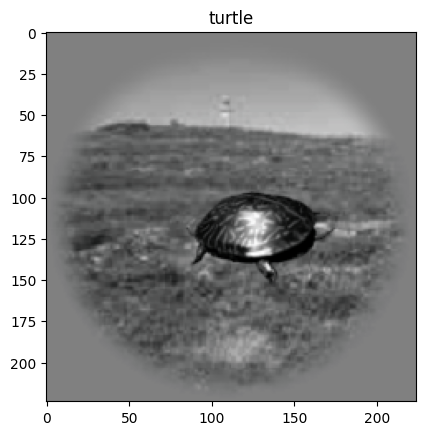

In [8]:
stim_idx = 5

visualize_img(stimulus_train, objects_train, stim_idx)

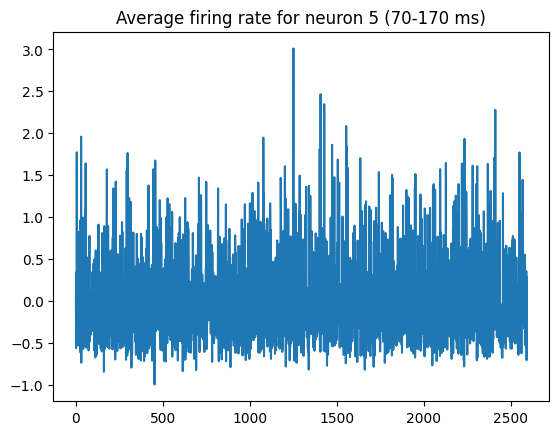

In [9]:
neuron_idx = 5

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:, neuron_idx])

In [29]:
train_dataset = ITDataset(stimulus_train, spikes_train)
val_dataset = ITDataset(stimulus_val, spikes_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [11]:
range(stimulus_train.shape[1])

range(0, 3)

## 2. Shallow CNN Model

In [22]:
# No regularization

class ShallowCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 512),
            nn.ReLU(),
            nn.Linear(512, 168)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

In [30]:
# With regularization

import torch.nn.functional as F

class ShallowCNN(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(64 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 168)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## 3. Save/Load Model Functions

In [31]:
model_dir = '/content/drive/MyDrive/nx414/cnn_states/ShallowCNN'
os.makedirs(model_dir, exist_ok=True)

def save_model(model, epoch):
    path = f'{model_dir}/{epoch}.pth'
    torch.save(model.state_dict(), path)
    # print(f'Model saved at: {path}')

def load_model(epoch='latest'):
    model = ShallowCNN()
    modelStates = glob.glob(f'{model_dir}/*.pth')
    if len(modelStates) and (epoch == 'latest' or isinstance(epoch, int)):
        modelEpochs = [int(f.split('/')[-1].replace('.pth', '')) for f in modelStates]
        if epoch == 'latest':
            epoch = max(modelEpochs)
        stateDict = torch.load(f'{model_dir}/{epoch}.pth', map_location='cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(stateDict)
        print(f'Model loaded from epoch {epoch}')
    else:
        print('No saved model found. Returning new untrained model.')
        epoch = 0
    model = model.cuda() if torch.cuda.is_available() else model
    model.eval()
    return model, epoch

## 4. Train Script

In [32]:
def train(model, train_loader, val_loader, epochs=10):
    loss_fn = nn.MSELoss()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

    model = model.cuda()

    train_losses = []
    val_r2_scores = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        with torch.no_grad():
            preds, targets = [], []
            for x_val, y_val in val_loader:
                x_val = x_val.cuda()
                pred = model(x_val).cpu().numpy()
                preds.append(pred)
                targets.append(y_val.numpy())

            preds = np.concatenate(preds)
            targets = np.concatenate(targets)
            r2 = r2_score(targets, preds)
            val_r2_scores.append(r2)

        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val R² = {r2:.4f}")

        # Save model at each epoch
        save_model(model, epoch + 1)

    return train_losses, val_r2_scores

## 5. Run Training

In [33]:
nb_epochs = 50

model = ShallowCNN()
train_losses, val_r2_scores = train(model, train_loader, val_loader, epochs=nb_epochs)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss = 24.3953, Val R² = -0.0220
Epoch 2: Train Loss = 0.1372, Val R² = -0.0197
Epoch 3: Train Loss = 0.1370, Val R² = -0.0171
Epoch 4: Train Loss = 0.1368, Val R² = -0.0147
Epoch 5: Train Loss = 0.1368, Val R² = -0.0125
Epoch 6: Train Loss = 0.1365, Val R² = -0.0108
Epoch 7: Train Loss = 0.1365, Val R² = -0.0094
Epoch 8: Train Loss = 0.1363, Val R² = -0.0082
Epoch 9: Train Loss = 0.1359, Val R² = -0.0073
Epoch 10: Train Loss = 0.1360, Val R² = -0.0067
Epoch 11: Train Loss = 0.1360, Val R² = -0.0061
Epoch 12: Train Loss = 0.1358, Val R² = -0.0057
Epoch 13: Train Loss = 0.1359, Val R² = -0.0054
Epoch 14: Train Loss = 0.1360, Val R² = -0.0051
Epoch 15: Train Loss = 0.1359, Val R² = -0.0051
Epoch 16: Train Loss = 0.1358, Val R² = -0.0050
Epoch 17: Train Loss = 0.1358, Val R² = -0.0048
Epoch 18: Train Loss = 0.1359, Val R² = -0.0048
Epoch 19: Train Loss = 0.1361, Val R² = -0.0048
Epoch 20: Train Loss = 0.1358, Val R² = -0.0048


KeyboardInterrupt: 

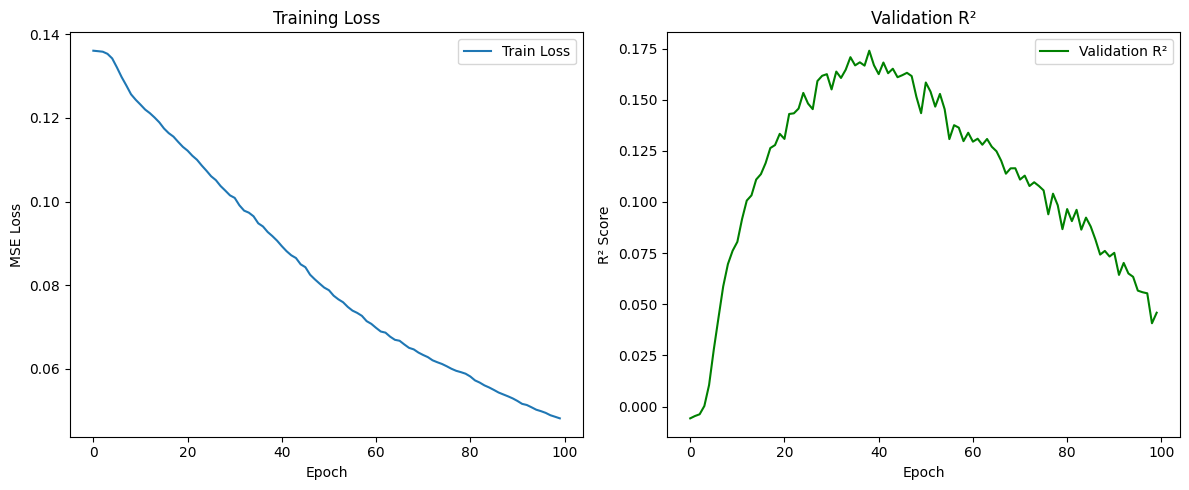

In [ ]:
plt.figure(figsize=(9, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_r2_scores, label='Validation R²', color='green')
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Validation R²")
plt.legend()

plt.tight_layout()
plt.show()

## 6. Predict on Validation Image

In [ ]:
def predict_and_plot(model, image, true_activity):
    model.eval()
    image_tensor = torch.tensor(image / 255.0, dtype=torch.float32).unsqueeze(0).cuda()
    with torch.no_grad():
        pred_activity = model(image_tensor).cpu().squeeze().numpy()

    plt.figure(figsize=(8, 4))
    plt.plot(true_activity, label='True Activity', marker='o', linestyle='-')
    plt.plot(pred_activity, label='Predicted Activity', marker='x', linestyle='--')
    plt.title("IT Neuron Activity Prediction")
    plt.xlabel("Neuron Index")
    plt.ylabel("Activity")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
spikes_train.shape

(2592, 168)

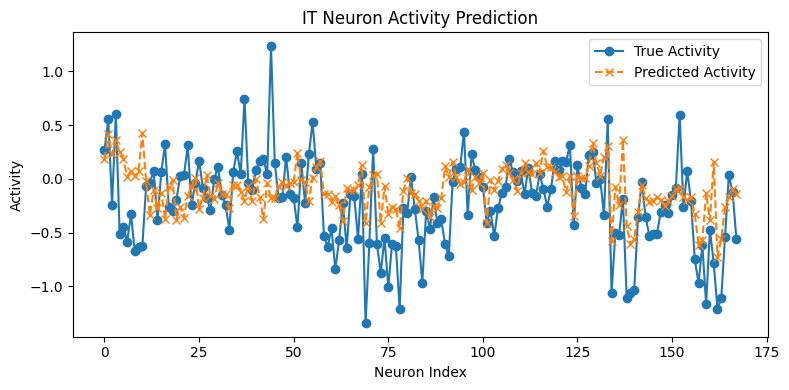

In [ ]:
sample_idx = 5
sample_image = stimulus_val[sample_idx]  # shape: (3, 224, 224)
sample_target = spikes_val[sample_idx]   # shape: (168,)
predict_and_plot(model, sample_image, sample_target)